In [1]:
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import inspect

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

import models
from models import get_accuracy

#### **Load and process dataset**

In [2]:
dataset = 'movielens'
use_gpu = 6

train_edges = np.load('data/' + dataset + '/train_edges.npy')
test_edges = np.load('data/' + dataset + '/test_edges.npy')

user_list_train = train_edges[:, 0]
user_list_test = test_edges[:, 0]
item_list_train = train_edges[:, 1]
item_list_test = test_edges[:, 1]
rating_list_train = train_edges[:, 2].astype('float32')
rating_list_test = test_edges[:, 2].astype('float32')

n_users = max(user_list_train.max(), user_list_test.max()) + 1 
n_items = max(item_list_train.max(), item_list_test.max()) + 1
n_samples_train = len(rating_list_train)
n_samples_test = len(rating_list_test)

print('n_users:', n_users)
print('n_items:', n_items)
print('n_samples_train:', n_samples_train)
print('n_samples_test:', n_samples_test)

if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

users = torch.tensor(user_list_train, device = device)
items = torch.tensor(item_list_train, device = device)
ratings = torch.tensor(rating_list_train, device = device, requires_grad = True)

users_test = torch.tensor(user_list_test, device = device)
items_test = torch.tensor(item_list_test, device = device)
ratings_test = torch.tensor(rating_list_test, device = device)

ratings_np = ratings.detach().to('cpu').int().numpy()
ratings_test_np = ratings_test.detach().to('cpu').int().numpy()

n_users: 943
n_items: 1682
n_samples_train: 159619
n_samples_test: 40381


#### **Function to test any model**

In [10]:
def test_model(algorithm, n_users, n_items, n_factors=16, T = 50, optim = 'adam', lr = 0.1, seed = 0, device = 'cpu'):
    
    torch.manual_seed(seed)
    model = getattr(models, algorithm)(n_users, n_items, n_factors).to(device)
    
    if optim == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    elif optim == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    else:
        raise ValueError('optimizer must be adam or sgd')

    loss_fn = torch.nn.BCELoss(reduction = 'mean')
    
    train_auc = []
    valid_auc = []

    for _ in tqdm(range(T)):
        model.eval()
        with torch.no_grad():
            y_hat = model(users, items).detach().to('cpu').numpy()
            y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
            train_auc.append(roc_auc_score(ratings_np, y_hat))
            valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))
        
        model.train()
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
    
    model.eval()
    loss = loss_fn(y_hat, ratings)
    meta_grad = torch.autograd.grad(loss, ratings)[0]
    print('max meta grad: ', meta_grad.max().item())
    print('min meta grad: ', meta_grad.min().item())

    with torch.no_grad():
        y_hat = model(users, items)
        y_hat_test = model(users_test, items_test)
        print('Training accuracy: ', get_accuracy(y_hat, ratings))
        print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
        print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
        print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))
        print('Max validation accuracy: ', max(valid_auc))
        print('Max validation AUC: ', max(valid_auc))

    plt.plot(train_auc, label = 'Training AUC')
    plt.plot(valid_auc, label = 'Validation AUC')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.title('AUROC vs epochs for {} algorithm'.format(algorithm))
    plt.show()

#### **Check available models**

In [32]:
[m[0] for m in inspect.getmembers(models, inspect.isclass) if m[1].__module__ == 'models']

['CF', 'CFD', 'GMF', 'GMFB', 'GMFD', 'MLP']

#### **Collaborative Filtering**

100%|██████████| 100/100 [00:05<00:00, 17.64it/s]


max meta grad:  0.00028649510932154953
min meta grad:  -inf
Training accuracy:  0.8908964395523071
Training AUC:  0.9603709697905022
Validation accuracy:  0.802976667881012
Validation AUC:  0.8762406432461607
Max validation accuracy:  0.8794441219763506
Max validation AUC:  0.8794441219763506


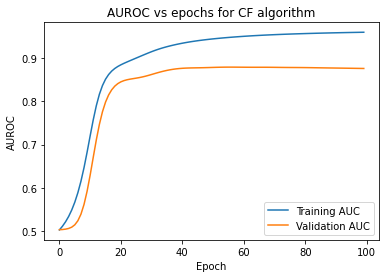

In [17]:
test_model('CF', n_users, n_items, n_factors = 8, T = 100, optim = 'adam', lr = 0.1, seed = 0, device = device)

#### **Collaborative Filtering with Dropout**

100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


max meta grad:  0.000278924941085279
min meta grad:  -inf
Training accuracy:  0.8507007360458374
Training AUC:  0.9290412689653224
Validation accuracy:  0.8184542059898376
Validation AUC:  0.898350637848977
Max validation accuracy:  0.8983991217310241
Max validation AUC:  0.8983991217310241


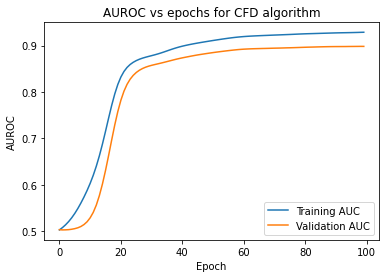

In [16]:
test_model('CFD', n_users, n_items, n_factors = 8, T = 100, optim = 'adam', lr = 0.1, seed = 0, device = device)

#### **GMF** 

100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


max meta grad:  0.00048661421169526875
min meta grad:  -inf
Training accuracy:  0.8938096165657043
Training AUC:  0.9618950143024907
Validation accuracy:  0.7989153265953064
Validation AUC:  0.8687259641332614
Max validation accuracy:  0.8755290589274325
Max validation AUC:  0.8755290589274325


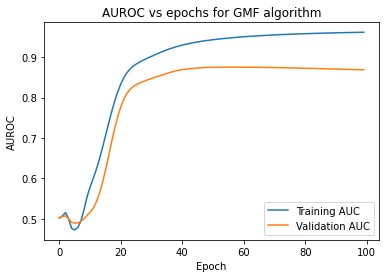

In [15]:
test_model('GMF', n_users, n_items, n_factors = 8, T = 100, optim = 'adam', lr = 0.1, seed = 0, device = device)

#### **GMF with Dropout**

100%|██████████| 100/100 [00:05<00:00, 17.68it/s]


max meta grad:  0.00018997567531187087
min meta grad:  -inf
Training accuracy:  0.8652353286743164
Training AUC:  0.9413065712172974
Validation accuracy:  0.8198657631874084
Validation AUC:  0.8999757752318336
Max validation accuracy:  0.9002915583141162
Max validation AUC:  0.9002915583141162


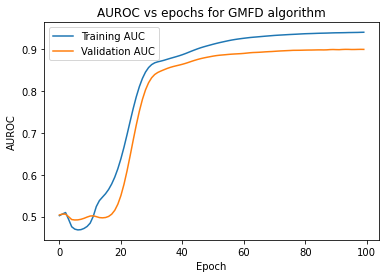

In [14]:
test_model('GMFD', n_users, n_items, n_factors = 8, T = 100, optim = 'adam', lr = 0.1, seed = 0, device = device)

#### **MLP algorithm**

100%|██████████| 100/100 [00:05<00:00, 17.70it/s]


max meta grad:  0.00014063442358747125
min meta grad:  -6.046116686775349e-05
Training accuracy:  0.8617896437644958
Training AUC:  0.9380643472349565
Validation accuracy:  0.8080780506134033
Validation AUC:  0.8881840991609833
Max validation accuracy:  0.8883168882782982
Max validation AUC:  0.8883168882782982


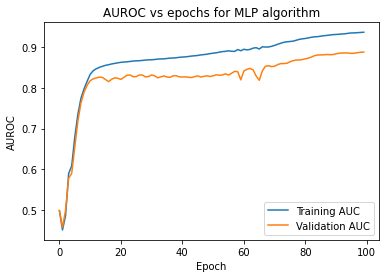

In [11]:
test_model('MLP', n_users, n_items, n_factors = 16, T = 100, optim = 'adam', lr = 0.1, seed = 0, device = device)

#### **GMF algorithm with user-item bias**

100%|██████████| 200/200 [00:11<00:00, 17.92it/s]


max meta grad:  0.0002295246667927131
min meta grad:  -inf
Training accuracy:  0.8737744092941284
Training AUC:  0.9485473606331404
Validation accuracy:  0.8142938613891602
Validation AUC:  0.8965669103576861
Max validation accuracy:  0.8982597149305726
Max validation AUC:  0.8982597149305726


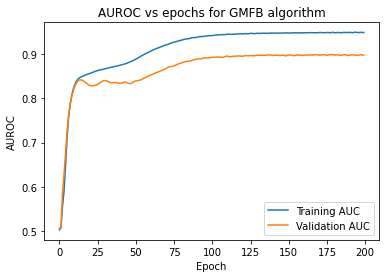

In [12]:
test_model('GMFB', n_users, n_items, n_factors = 8, T = 200, optim = 'adam', lr = 0.1, seed = 0, device = device)